In [9]:
#DB
import os
import psycopg2

# Helpers
import numpy as np
import qgrid
from tqdm import tqdm_notebook
import time
import pandas as pd

# Evaluation
from gap import define_k

# Plots
import matplotlib.pyplot as plt

## Connect to DB

In [2]:
connection = psycopg2.connect(user = "machineteaching",
                                  password = "***REMOVED***",
                                  host = "localhost",
#                                   port = "5432",
                                  database = "machineteaching")
connection.autocommit=True
cursor = connection.cursor()

In [37]:
%%time

vectorizers = ['CountVectorizer',
               'TfidfVectorizer', 
               'NCutVectorizer']
min_df = np.arange(0.05, 0.5, 0.05)
binary = [True, False]
cluster_methods = ['nmf', 'lda']
#, 'hierarchical', 'gaussian_mixture', 'spectral_clustering']
metric = ['correlation', 'euclidean', 'cosine']

topics = ["bbc2", "bbc3", "bbc4", "bbc5"]


# Testing how the metrics work for several group of topics
for topic_list in tqdm_notebook(topics, desc="docs"):
    
    # Grid search
    for v in tqdm_notebook(vectorizers, desc="vectorizer", leave=False):
        for m in tqdm_notebook(min_df, desc="min_df", leave=False):
            for b in tqdm_notebook(binary, desc="binary", leave=False):
                for dist in tqdm_notebook(metric, desc="metric", leave=False):
                    for method in tqdm_notebook(cluster_methods, desc="method", leave=False):
                        # Get results for each combination and get best k value
                        cols = ["experiment_id", "dataset", "k", "gap", "gap_std", "silhouette", "silhouette_samples", 
                                "coherence_samples", "coherence_med", "coherence_std", "coherence_k"]

                        query = "SELECT %s from experiments where " % ", ".join(cols)
                        where_clause = [("vectorizer", v), ("min_df", m), ("is_binary", b), 
                                        ("distance", dist), ("method", method)]
                        query += " AND ".join(["%s = '%s'" % item for item in where_clause])
                        cursor.execute(query)
                        r = cursor.fetchall()
                        df = pd.DataFrame(r, columns=cols)
                        
                        if df.shape[0]:
                            experiment_id = df['experiment_id'].values.tolist()[0]

                            # Get measure values
                            gaps_original = df['gap'].values.tolist()
                            gaps = gaps_original[:]
                            error = df['gap_std'].values.tolist()
                            sils = df['silhouette'].values.tolist()
                            coherence = df['coherence_med'].values.tolist()
                            coherence_std = df['coherence_std'].values.tolist()
                            coherence_array = df['coherence_samples'].values.tolist()

                            # Gap
                            gap_k, gap_k2 = define_k(gaps, error)
                            # Silhouette
                            silhouette_k = np.argsort(np.asarray(sils))[::-1][0]+2
                            silhouette_k2 = np.argsort(np.asarray(sils))[::-1][1]+2
                            # Coherence
                            coherence_med = []
    #                         coherence_std = []
                            for c in coherence_array:
                                coherence_med.append(np.median(np.asarray([i for i in c if str(i) != 'nan'])))
    #                             coherence_std.append(np.std(np.asarray([i for i in c if str(i) != 'nan'])))
                            coherence_k = np.argsort(np.asarray(coherence_med))[::-1][0]+2
                            coherence_k2 = np.argsort(np.asarray(coherence_med))[::-1][1]+2

                            cols = ["experiment_id", "gap_k", "gap_k2", "silhouette_k", "silhouette_k2", "coherence_k", "coherence_k2"]
                            insert_query = "INSERT INTO EXPERIMENTS_RESULT (%s) VALUES " % ", ".join(cols)
                            values = [experiment_id, gap_k, gap_k2, silhouette_k, silhouette_k2, coherence_k, coherence_k2]
                            values = [int(i) for i in values]
                            insert_query += "(" + ", ".join(["%s"]*len(values)) + ")"
                            query = cursor.mogrify(insert_query, values)
                            try:
                                cursor.execute(query)
                            except psycopg2.IntegrityError:
                                pass
#                         break
#                     break
#                 break
#             break
#         break
#     break

/home/lmoraes/miniconda3/envs/machine_teaching/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  



CPU times: user 42.6 s, sys: 1.51 s, total: 44.1 s
Wall time: 3min 54s


In [62]:
# Get experiment conditions
exp_id = 122
cols = ["vectorizer", "min_df", "is_binary", "distance", "method"]
query = "SELECT %s from experiments where experiment_id = %s" % (", ".join(cols), exp_id) 
cursor.execute(query)
r = cursor.fetchall()
r[0]
where_clause = zip(*[cols, r[0]])

# Get all k
cols = ["experiment_id", "dataset", "k", "gap", "gap_std", "silhouette", "silhouette_samples", 
                                "coherence_samples", "coherence_med", "coherence_std", "coherence_k"]

query = "SELECT %s from experiments where " % ", ".join(cols)
query += " AND ".join(["%s = '%s'" % item for item in where_clause])
cursor.execute(query)
r = cursor.fetchall()
df = pd.DataFrame(r, columns=cols)

gaps_original = df['gap'].values.tolist()
gaps = gaps_original[:]
error = df['gap_std'].values.tolist()
sils = df['silhouette'].values.tolist()
coherence = df['coherence_med'].values.tolist()
coherence_std = df['coherence_std'].values.tolist()
coherence_array = df['coherence_samples'].values.tolist()

# Get measure values
gaps_original = df['gap'].values.tolist()
gaps = gaps_original[:]
error = df['gap_std'].values.tolist()
sils = df['silhouette'].values.tolist()
coherence = df['coherence_med'].values.tolist()
coherence_std = df['coherence_std'].values.tolist()
coherence_array = df['coherence_samples'].values.tolist()

# Gap
gap_k, gap_k2 = define_k(gaps, error)
# Silhouette
silhouette_k = np.argsort(np.asarray(sils))[::-1][0]+2
silhouette_k2 = np.argsort(np.asarray(sils))[::-1][1]+2
# Coherence
coherence_med = []
#                         coherence_std = []
for c in coherence_array:
    coherence_med.append(np.median(np.asarray([i for i in c if str(i) != 'nan'])))
#                             coherence_std.append(np.std(np.asarray([i for i in c if str(i) != 'nan'])))
coherence_k = np.argsort(np.asarray(coherence_med))[::-1][0]+2
coherence_k2 = np.argsort(np.asarray(coherence_med))[::-1][1]+2

/home/lmoraes/miniconda3/envs/machine_teaching/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


In [60]:
df

,experiment_id,dataset,k,gap,gap_std,silhouette,silhouette_samples,coherence_samples,coherence_med,coherence_std,coherence_k
0,122,bbc2,5,-0.330245,0.020410,0.032902,"[0.0637975, 0.0537108, 0.16985, 0.0345861, 0.1...","[-1.54702, -3.56375, -3.65616, -2.34255, -3.17...",-3.17055,0.802142,5
1,127,bbc2,6,-0.334212,0.016845,0.047394,"[0.0556416, 0.0433508, 0.153089, 0.0614036, 0....","[-1.983, -3.59234, -3.21547, -4.29214, -3.7004...",-3.64642,0.785485,6
2,135,bbc2,7,-0.313414,0.023657,0.034345,"[-0.105722, -0.0314994, 0.138871, 0.0564991, 0...","[-2.6056, -2.89574, -2.92194, -3.84857, -3.429...",-3.42919,0.886936,7
3,140,bbc2,8,-0.330359,0.017864,0.032001,"[-0.111072, -0.0451676, 0.124545, 0.0547686, 0...","[-2.23125, -2.85773, -3.22107, -4.98671, -3.20...",NaN,NaN,8
4,146,bbc2,9,-0.330122,0.018909,0.033926,"[-0.110191, -0.0356851, 0.132098, -0.0560888, ...","[-1.95003, -2.55686, -2.81577, -2.87771, -3.27...",-3.27686,1.282360,9
5,152,bbc2,10,NaN,NaN,0.074761,"[0.0689213, 0.0601012, 0.159788, -0.0557, 0.16...","[-2.0873, -2.95459, -3.52577, -3.90273, -4.491...",-3.86699,0.862012,9
6,157,bbc2,11,NaN,NaN,0.035814,"[-0.0366373, 0.0515053, 0.0332522, -0.0630054,...","[-2.16294, -3.01997, -4.31854, -4.60517, -4.60...",-4.00546,0.927794,10
7,165,bbc2,12,NaN,NaN,0.052427,"[0.0756551, 0.0519188, 0.106314, 0.0707328, 0....","[-2.24478, -2.91631, -3.45139, -4.60517, nan, ...",NaN,NaN,11


In [63]:
%matplotlib notebook

<IPython.core.display.Javascript object>


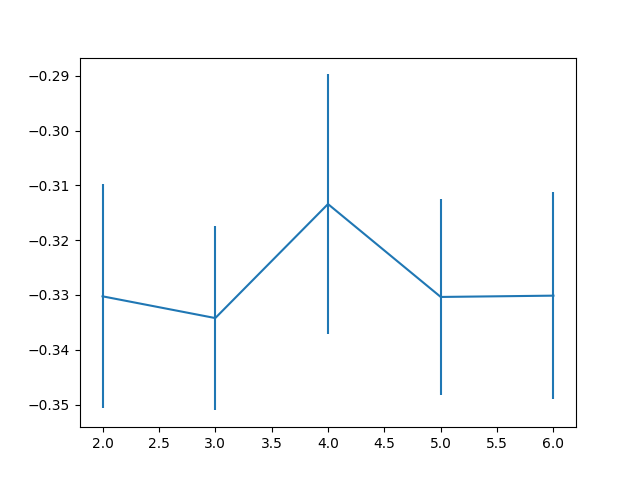

k = 2
2nd k = 3


In [64]:
# Plot data
plt.figure()
plt.errorbar(range(2,len(gaps)+2), gaps_original, yerr=error)
plt.show()

# Get best k
print("k = %d" % gap_k)
print("2nd k = %d" % gap_k2)

<IPython.core.display.Javascript object>


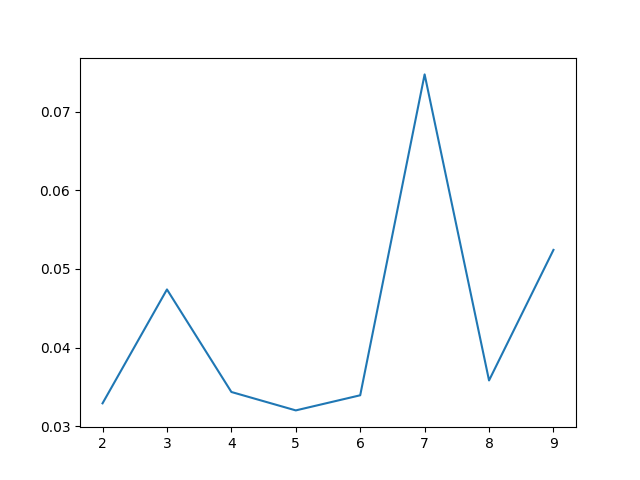

k = 7
2nd k = 9


In [65]:
# Plot data
plt.figure()
plt.plot(range(2,len(sils)+2), sils)
plt.show()

# Get best k
print("k = %d" % silhouette_k)
print("2nd k = %d" % silhouette_k2)

<IPython.core.display.Javascript object>


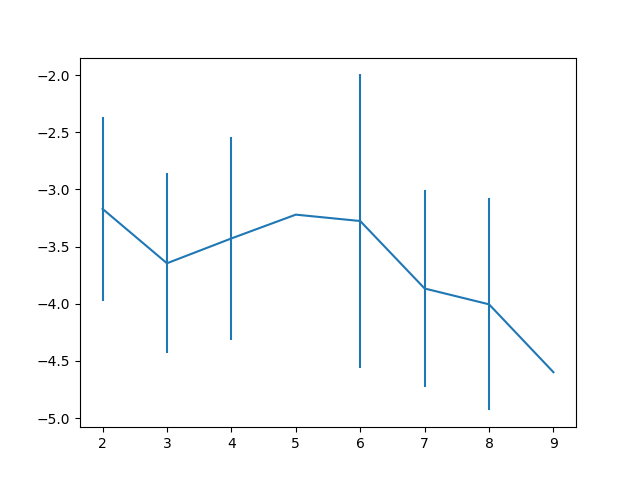

k = 2
2nd k = 5
CPU times: user 24 ms, sys: 0 ns, total: 24 ms
Wall time: 42.9 ms


In [66]:
%%time

# Plot data
plt.figure()
plt.errorbar(range(2,len(coherence)+2), coherence_med, yerr=coherence_std)
plt.show()

# Get best k
# Get best k
print("k = %d" % coherence_k)
print("2nd k = %d" % coherence_k2)

<IPython.core.display.Javascript object>


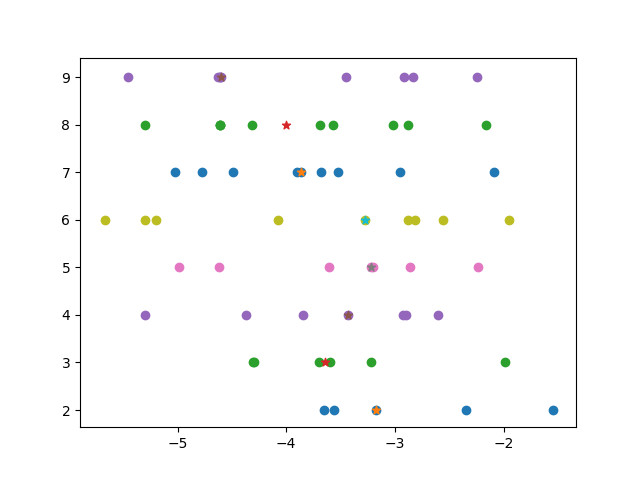

In [67]:
plt.figure()
for idx, i in enumerate(coherence_array):
    median = np.median([item for item in i if str(item) != 'nan'])
    plt.scatter(i, [idx+2]*len(i))
    plt.scatter(median, idx+2, marker="*")

In [48]:
import pickle

with open("clustering_bcc.pkl", "wb") as pklfile:
    pickle.dump(df, pklfile)